This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks). 

## BSL

[Bayesian synthethic likelihood](https://doi.org/10.1080/10618600.2017.1302882) (BSL) methods sample an approximate posterior distribution based on comparison between the observed data and a [synthetic likelihood](https://www.nature.com/articles/nature09319) estimated based on repeated simulations. 

This tutorial demonstrates how to use various BSL methods for LFI in ELFI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import elfi
from elfi.methods.bsl import pre_sample_methods, pdf_methods

seed = 1
np.random.seed(seed)

We use the MA(2) model introduced in the [ELFI tutorial](https://elfi.readthedocs.io/en/latest/usage/tutorial.html#inference-with-elfi-case-ma-2-model).

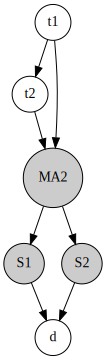

In [2]:
from elfi.examples import ma2
m = ma2.get_model(n_obs=50, true_params=[0.6, 0.2], seed_obs=seed)
elfi.draw(m)

### Tutorial example

BSL in ELFI proceeds so that we first define how the observed and simulated data are converted to approximate likelihood scores and then sample the approximate posterior distribution estimated based on the likelihood scores. Here we demonstrate the process with standard BSL.

1. Likelihood calculation

BSL compares features calculated based observed and simulated data to estimate the likelihood that the same parameter values produced the observed and simulated data. 
In practice the approximate likelihood that certain parameters `params` produced the observed data is calculated based on the observed features and a distribution model that describes the feature distribution at `params`. The model is estimated based on `nsim_round` features simulated with `params`.

- Features

Features used in likelihood calculation must be included as observable nodes in the ELFI model. Observable nodes in our example include the simulator node `MA2` and the summaries `S1` and `S2`. To match examples used in the BSL literature, we do not use summaries but estimate likelihood scores based on the observed and simulated data.

In [3]:
feature_names = 'MA2'

As the standard likelihood calculation method models the simulated feature distribution as multivariate normal, it is useful to visualise feature distributions to assess normality. Here we choose some parameter values `params` that we believe could reproduce the observed data and visualise the feature distribution over `nsim` repeated simulations. If the feature distributions deviate from normal, a semiparametric likelihood calculation method could be more appropriate than the standard likelihood calculation method.

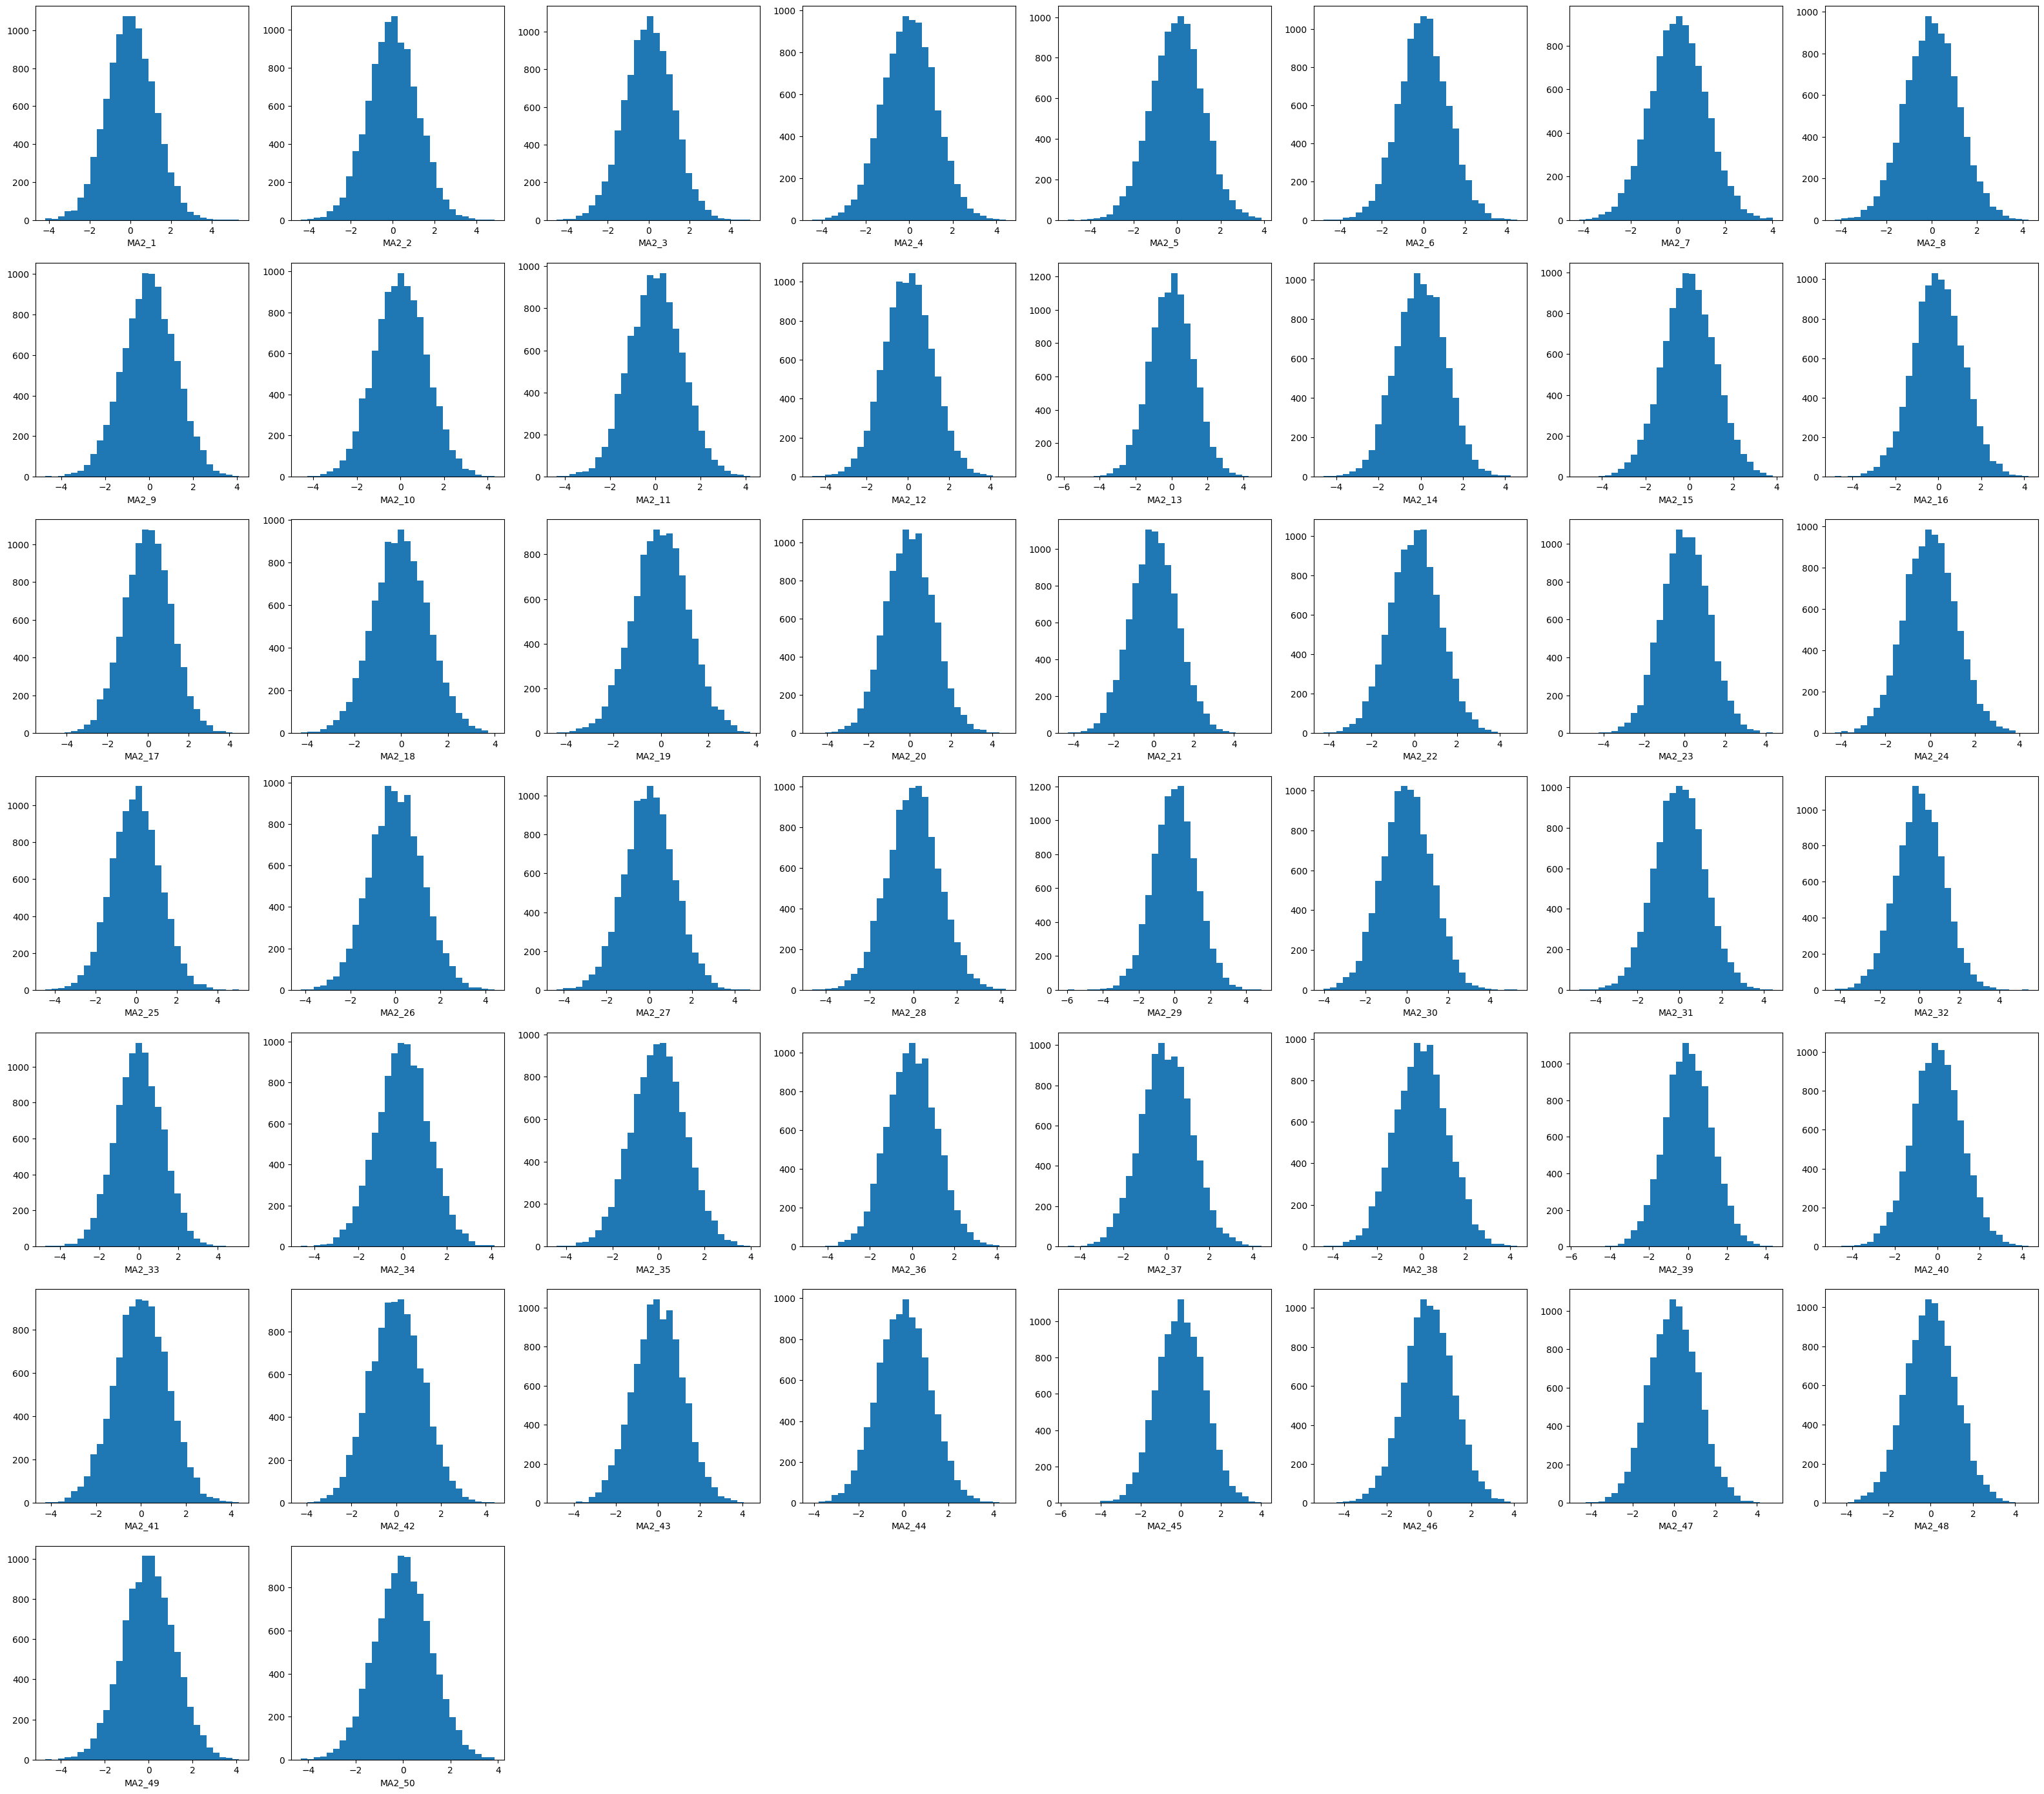

In [4]:
params = {'t1': 0.6, 't2': 0.2}
nsim = 10000
pre_sample_methods.plot_features(m, params, nsim, feature_names, seed=seed)

- Likelihood calculation method

The likelihood calculation methods available in ELFI include `standard_likelihood`, `unbiased_likelihood`, `semiparametric_likelihood`, and `robust_likelihood`. We can either choose a method from this list or provide a custom method that takes the observed and simulated data as input and returns an appropriate likelihood score.

Here we choose the standard synthetic likelihood calculation method. This method approximates the simulated feature distribution with a multivariate normal distribution.

In [5]:
likelihood = pdf_methods.standard_likelihood()

- Simulation count

BSL methods are most computationally efficient when `nsim_round` is selected so that the standard deviation between log-likelihood scores is between 1 and 2. Here we calculate the standard devitation between `M` likelihood scores calculated based on `nsim` features simulated with `params`.

In [6]:
params = {'t1': 0.6, 't2': 0.2}
nsim = [100, 300, 500]
std_value = pre_sample_methods.log_SL_stdev(m, params, nsim, feature_names, likelihood=likelihood, M=100, seed=seed)
std_value

array([9.51130205, 2.29975692, 1.8201485 ])

The simulation count that is needed to reduce the standard deviation to the recommended level depends on the feature dimension, and we see that with the selected features, around 500 simulations are needed. 

In [7]:
nsim_round = 500

2. BSL sampler

With `feature_names`, `likelihood`, and `nsim_round`, we have decided how the likelihood scores are calculated and can create a `BSL` instance to sample the approximate posterior distribution estimated based on the selected likelihood scores.

In [8]:
standard_bsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

We can see here that `feature_names` and `likelihood` are optional parameters. `feature_names` defaults to all summary nodes in the model `m` and `likelihood` defaults to the standard synthetic likelihood calculation method. Other notable parameters include `batch_size` which defaults to the simulation count `nsim_round`. 

To proceed, we call the `sample` method to set sampler parameters and sample a chain from the approximate posterior distribution. BSL uses MCMC sampling with a Metropolis-Hastings step. Required parameters are the sample size and a covariance matrix for the proposal distribution. Here we also set the initial parameter values `params0` to the true parameter values.

In [9]:
mcmc_iterations = 2000  # sample size
est_post_cov = np.array([[0.02, 0.01], [0.01, 0.02]])  # covariance matrix for the proposal distribution
params0 = [0.6, 0.2]
res = standard_bsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [10]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 1000000
MCMC Acceptance Rate: 0.219
Parameter                Mean               2.5%              97.5%
t1:                     0.426              0.142              0.740
t2:                     0.234             -0.044              0.467


As MCMC draws correlated samples, it is useful to estimate the effective sample size (ESS) as an estimate of the equivalent number of independent iterations that the MCMC chain represents.

In [11]:
res.compute_ess()

{'t1': 69.85051011126637, 't2': 86.11215292286599}

We can also visualise the chain with `plot_traces`.

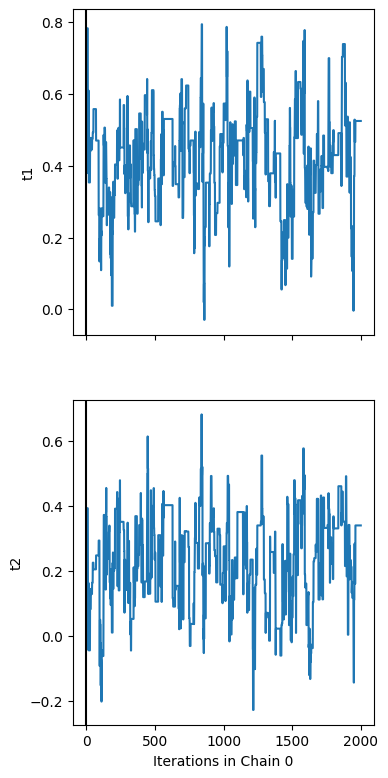

In [12]:
res.plot_traces();

Finally the acquired sample can visualised with `plot_marginals` and `plot_pairs`.

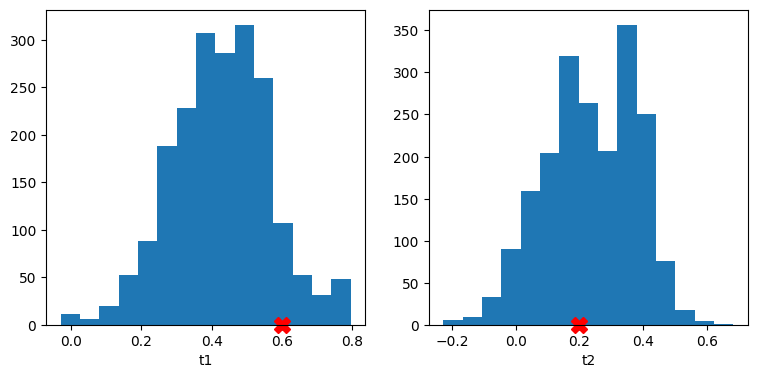

In [13]:
mbins = 15
res.plot_marginals(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

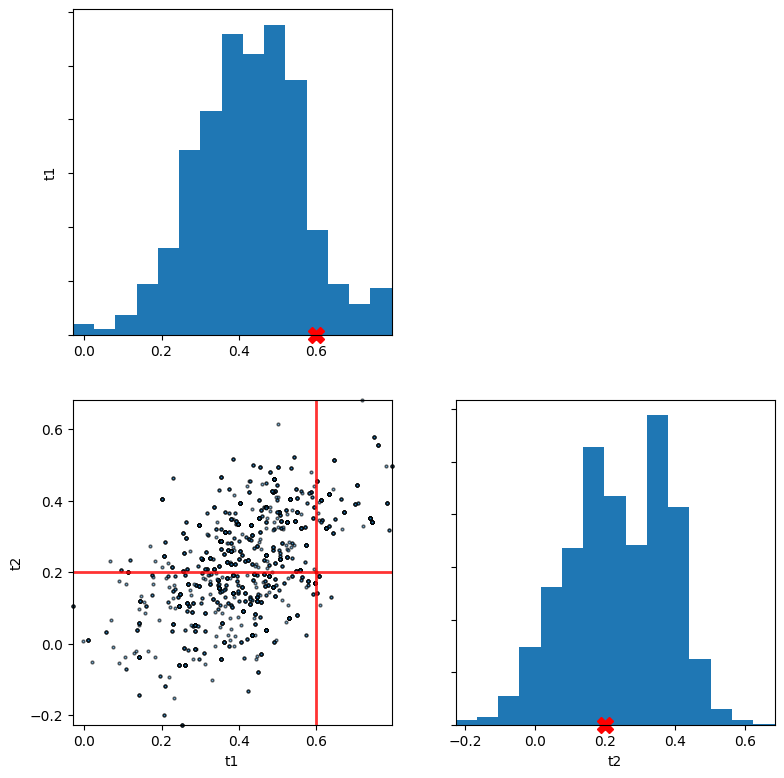

In [14]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

This concludes the standard BSL example. The next sections first discuss how to reduce the simulation count `nsim_round` and then introduce alternative likelihood calculation methods.

### Covariance matrix estimation

We learned that synthetic likelihood calculation uses `nsim_round` simulations to estimate the feature distribution at all proposed parameter values. The simulation count needed to calculate reliable estimates for the feature distribution mean and covariance increases with feature dimension. The covariance matrix estimate in particular becomes unstable if `nsim_round` is too small. However we can reduce the required simulation count with penalised covariance estimation methods.

The covariance estimation in `standard_likelihood` and `semiparametric_likelihood` is controlled with `shrinkage` and `penalty` options. `shrinkage` selects the penalised covariance matrix estimation method (`'warton'` or `'glasso'`) and `penalty` controls a parameter used in estimation.  The examples in this section use `standard_likelihood`.

Let us visualise an example covariance matrix estimated based on `nsim` simulations at `params`.

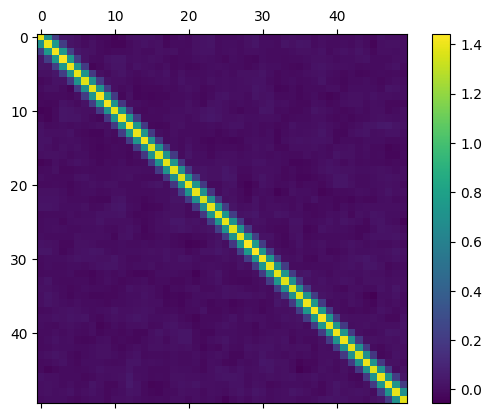

In [15]:
params = {'t1': 0.6, 't2': 0.2}
nsim = 10000
pre_sample_methods.plot_covariance_matrix(m, params, nsim, feature_names, seed=seed)

Since consecutive features are correlated and have non-zero between-feature covariances, we would loose information with `shrinkage='warton'` which biases all between-feature covariances towards zero. However as most between-feature covariances are close to zero, a sparse estimate that retains some covariance structure could be appropriate.  Hence we choose `shrinkage='glasso'` which uses [graphical lasso](https://scikit-learn.org/stable/modules/covariance.html#sparse-inverse-covariance) to estimate a sparse inverse covariance matrix.

In addition to the likelihood calculation and covariance estimation methods, we must choose the `penalty` parameter used in covariance estimation. We can use `select_penalty` method to find parameter values that result in log-likelihood scores with standard deviation closest to a reference value `sigma` for selected simulation counts.

In [16]:
likelihood = pdf_methods.standard_likelihood()
shrinkage = 'glasso'
sigma = 1.5
nsim = [100, 300, 500]
params = {'t1': 0.6, 't2': 0.2}
penalty, std_value = pre_sample_methods.select_penalty(m, nsim, params, feature_names, sigma=sigma, shrinkage=shrinkage, likelihood=likelihood, seed=seed)

In [17]:
std_value

array([1.40011255, 1.54953813, 1.47654265])

In [18]:
penalty

array([0.12245643, 0.01657268, 0.01356856])

Here we reach the same standard deviation at all simulation counts as the recommended penalty increases to compensate for the decrease in simulation count. However, as we do not want to distort the estimated covariance matrix, we should choose a simulation count that works with a reasonably small penalty value.

Let us update the likelihood calculation method and simulation count:

In [19]:
likelihood = pdf_methods.standard_likelihood(shrinkage='glasso', penalty=penalty[1])
nsim_round = nsim[1]

This method is known as [BSLasso](https://doi.org/10.1080/10618600.2018.1537928).

In [20]:
bslasso = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [21]:
res = bslasso.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [22]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 597000
MCMC Acceptance Rate: 0.259
Parameter                Mean               2.5%              97.5%
t1:                     0.429              0.136              0.761
t2:                     0.221             -0.177              0.650


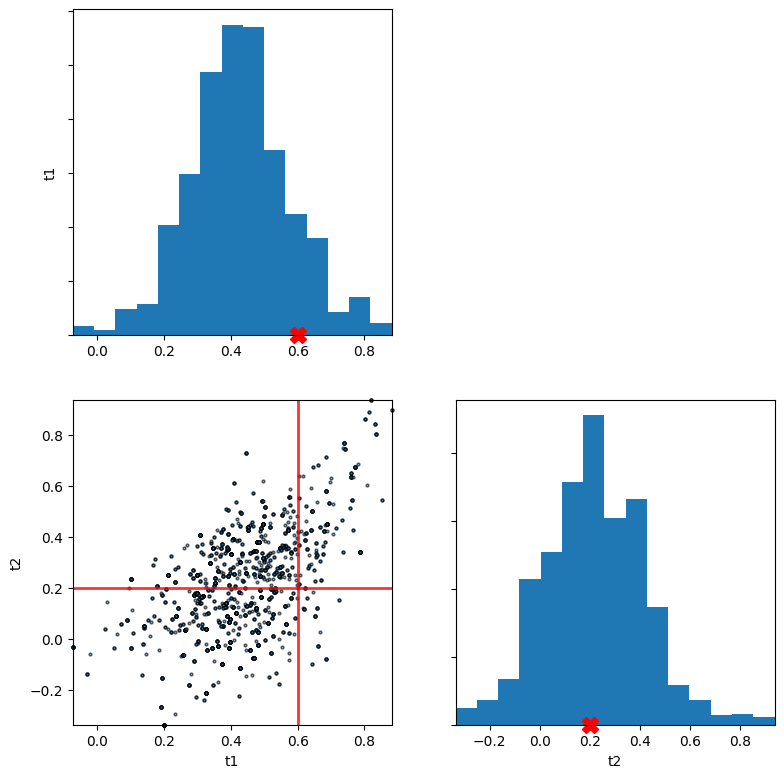

In [23]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

We observed above that the features used in this example have a covariance structure that can be approximated with a sparse covariance matrix. If the covariance structure is expected to be quite constant with respect to the simulator parameters, we can also estimate a whitening transformation to decorrelate the features prior to covariance matrix estimation. This should remove the between-feature covariances and allow for more reduction in the simulation count. 

We estimate the transformation matrix based on `nsim` features simulated with `params` that we believe could reproduce the observed data.

In [24]:
likelihood_type = 'standard'
nsim = 20000
params = {'t1': 0.6, 't2': 0.2}
W = pre_sample_methods.estimate_whitening_matrix(m, nsim, params, feature_names, likelihood_type=likelihood_type)

When a whitening transformation is used, `shrinkage='warton'` is recommended as the penalised covariance estimation method. This accepts `penalty` between 0 and 1. Since we expect to have decorrelated features, we can choose for example `penalty=0.8`, or we can use `select_penalty` to find suitable values as in the previous example. In case we use `select_penalty`, the whitening transformation is included as an additional input.

In [25]:
likelihood = pdf_methods.standard_likelihood()
shrinkage = 'warton'
sigma = 1.5
nsim = [100, 300]
params = {'t1': 0.6, 't2': 0.2}
penalty, std_value = pre_sample_methods.select_penalty(m, nsim, params, feature_names, whitening=W, sigma=sigma, shrinkage=shrinkage, likelihood=likelihood, seed=seed)

In [26]:
std_value

array([1.50367104, 1.4942562 ])

In [27]:
penalty

array([0.68, 0.4 ])

Let us update the likelihood calculation method and simulation count:

In [28]:
likelihood = pdf_methods.standard_likelihood(whitening=W, shrinkage=shrinkage, penalty=penalty[0])
nsim_round = nsim[0]

This method is known as [wBSL](https://doi.org/10.1080/10618600.2021.1979012).

In [29]:
wbsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [30]:
res = wbsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [31]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 200000
MCMC Acceptance Rate: 0.285
Parameter                Mean               2.5%              97.5%
t1:                     0.414              0.099              0.776
t2:                     0.220             -0.085              0.530


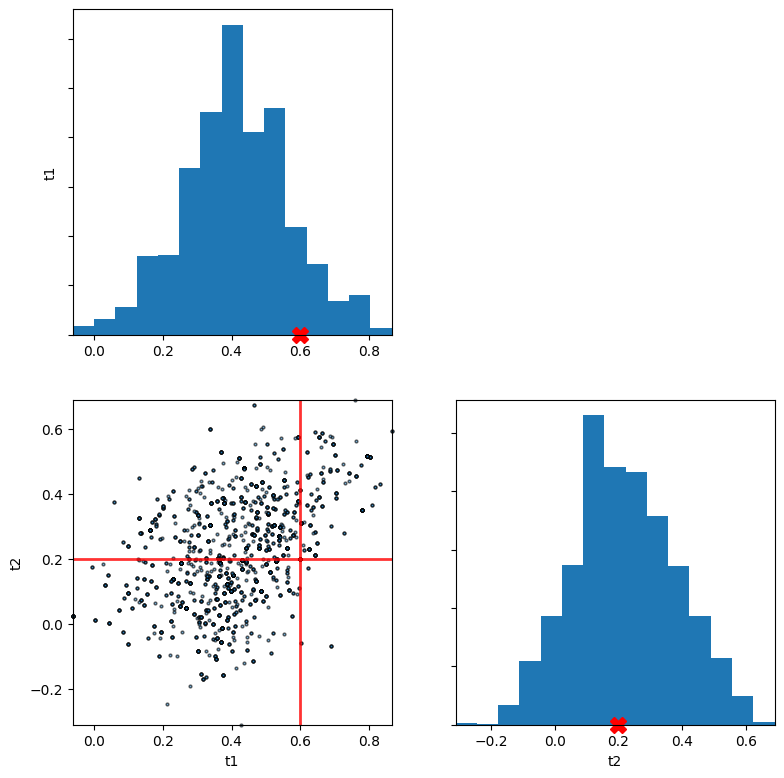

In [32]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

### Robust likelihood calculation

The previous examples all used `standard_likelihood` which models the simulated feature distribution as multivariate normal. Alternatives include the `semiparametric_likelihood` that relaxes the normality assumption and `robust_likelihood` that can be used to compensate for model misspecification.

Let us start with `semiparametric_likelihood`.

In [33]:
likelihood = pdf_methods.semiparametric_likelihood()
nsim_round = 500

BSL with semi-parametric synthetic likelihood calculation is known as [semiBSL](https://link.springer.com/article/10.1007/s11222-019-09904-x)

In [34]:
semibsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [35]:
res = semibsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [36]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 1000000
MCMC Acceptance Rate: 0.254
Parameter                Mean               2.5%              97.5%
t1:                     0.410              0.141              0.705
t2:                     0.213             -0.043              0.499


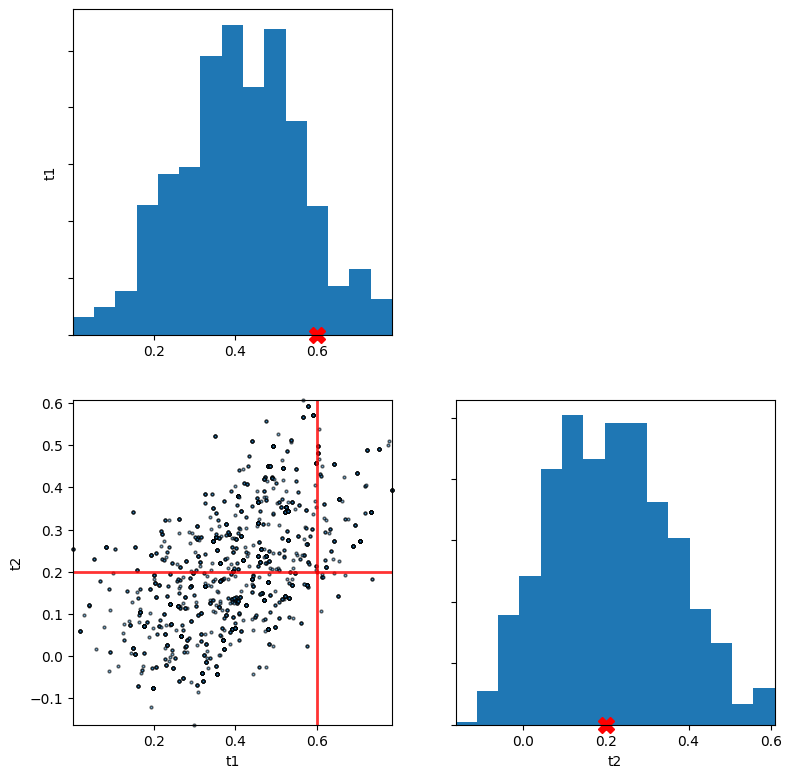

In [37]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

Semi-parametric likelihood calculation can also be combined with a whitening transformation and penalised covariance matrix estimation. This version is known as [wsemiBSL](https://doi.org/10.48550/arXiv.2007.01485).

Finally we demonstrate how the so-called [robust BSL](https://doi.org/10.1080/10618600.2021.1875839) (R-BSL) methods use  `robust_likelihood` to perform parameter inference even when the simulator model is unable to replicate the observed features. The robust likelihood calculation method has free parameters that adjust either the sample mean or sample covariance to compensate for model misspecification, and the R-BSL methods sample both the simulator parameters and the free parameters `gamma`.

We run the last examples with summarised data.

In [38]:
feature_names = ['S1', 'S2']

We can choose either `robust_likelihood('mean')` or `robust_likelihood('variance')`. We start with mean adjustment.

In [39]:
likelihood = pdf_methods.robust_likelihood('mean')
nsim_round = 500

In [40]:
rbsl_m = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

R-BSL methods use a slice sampler for the `gamma` parameters, and the `sample` method is now used to set both the MCMC and slice sampler parameters. The slice sampler parameters include step size `w`, maximum iteration count `max_iter`, and a parameter `tau` that scales the prior distribution used for `gamma`. Here we use the default values for `w` and `max_iter` but set the prior distribution scale `tau` to a small value to indicate that we do not believe that the model is misspecified.


In [41]:
res = rbsl_m.sample(mcmc_iterations, est_post_cov, params0=params0, tau=0.1)

Progress [==================================================] 100.0% Complete


In [42]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 977000
MCMC Acceptance Rate: 0.658
Parameter                Mean               2.5%              97.5%
t1:                     0.383             -0.022              0.820
t2:                     0.219             -0.226              0.935


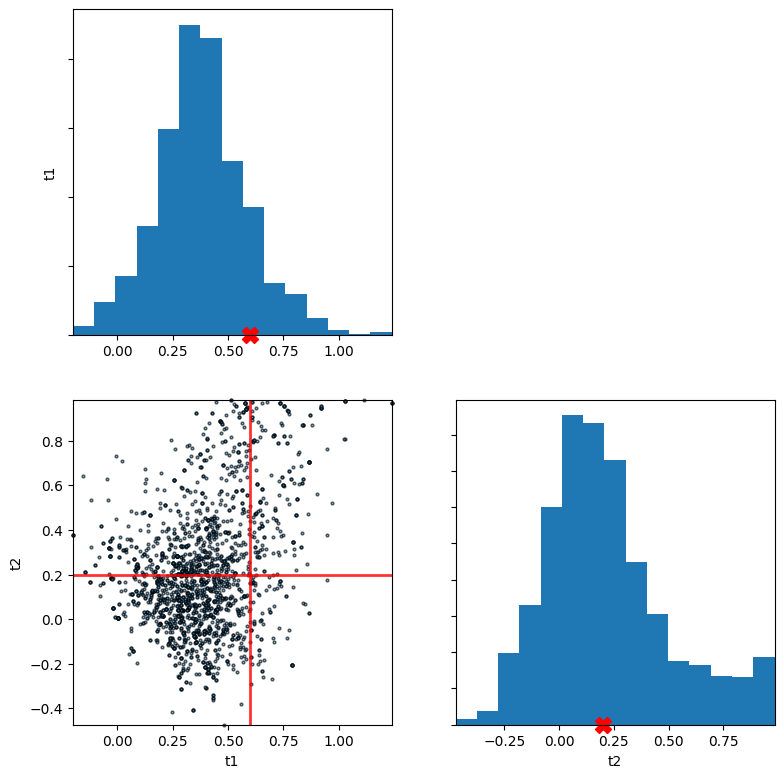

In [43]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

We can also visualise the sampled `gamma` parameters to see how the sample mean was adjusted in the accepted sample. Each feature is adjusted separately so the `gamma` parameter dimension matches the selected feature dimension.

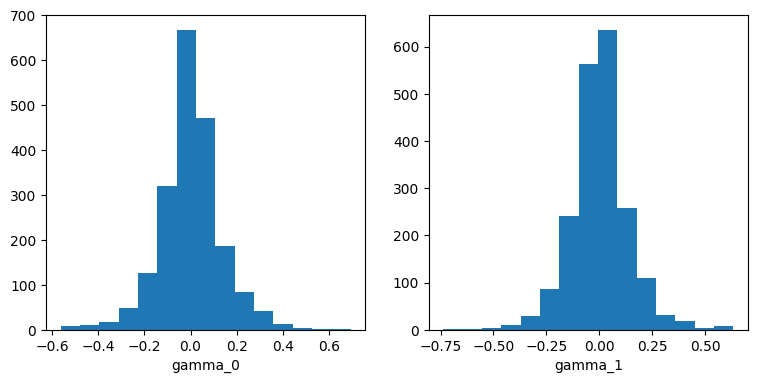

In [44]:
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_m.observed.size)], np.transpose(res.outputs['gamma'])))
elfi.visualization.visualization.plot_marginals(gamma_dict, bins=mbins);

R-BSL with variance adjustment follows the same process:

In [45]:
likelihood = pdf_methods.robust_likelihood('variance')

In [46]:
rbsl_v = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [47]:
res = rbsl_v.sample(mcmc_iterations, est_post_cov, params0=params0, tau=0.1)

Progress [==================================================] 100.0% Complete


In [48]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 973500
MCMC Acceptance Rate: 0.675
Parameter                Mean               2.5%              97.5%
t1:                     0.412              0.007              0.888
t2:                     0.166             -0.356              0.778


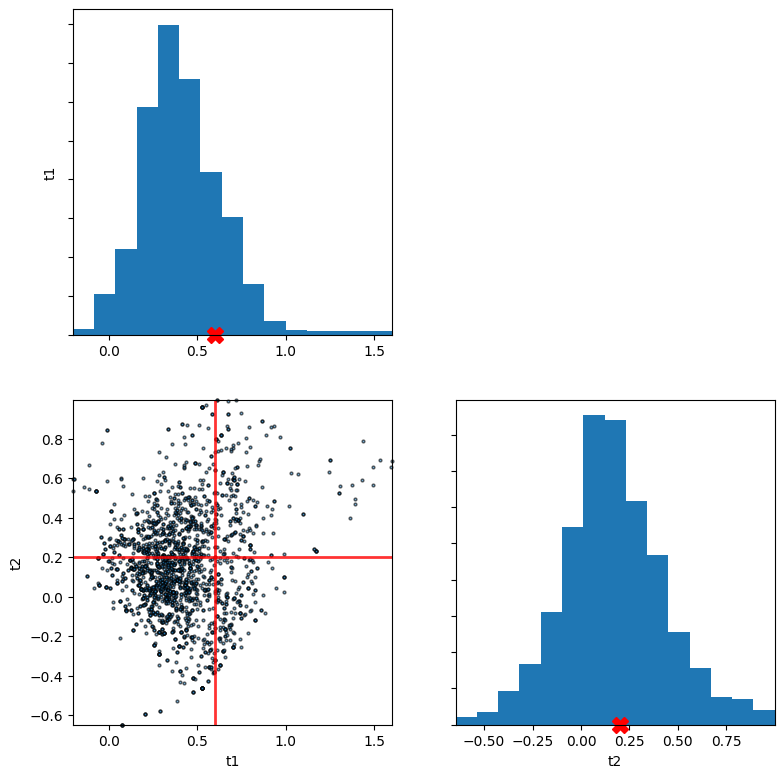

In [49]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

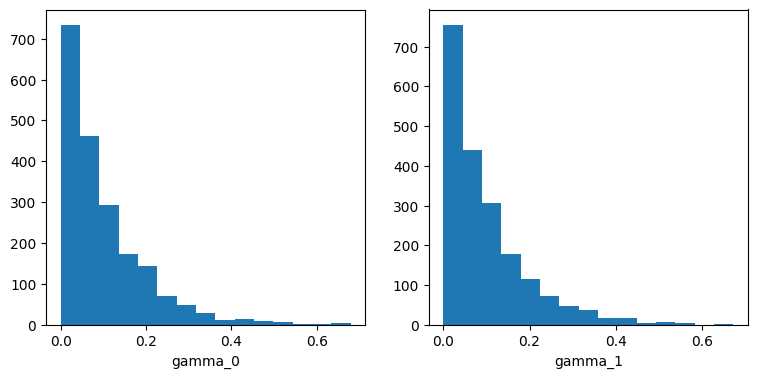

In [50]:
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_v.observed.size)], np.transpose(res.outputs['gamma'])))
elfi.visualization.visualization.plot_marginals(gamma_dict, bins=mbins);

### Parallelising simulations

To parallelise the simulated feature generation in BSL, we can choose a batch size that is smaller than the simulation count and let an appropriate ELFI client run batches in parallel.

In [51]:
elfi.set_client('multiprocessing')
bsl = elfi.BSL(m, 200, batch_size=50, seed=seed)
res = bsl.sample(mcmc_iterations, est_post_cov, bar=False)